In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rc('font', family='Verdana')

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
sample_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# **Пропущенные значения**

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


<Axes: >

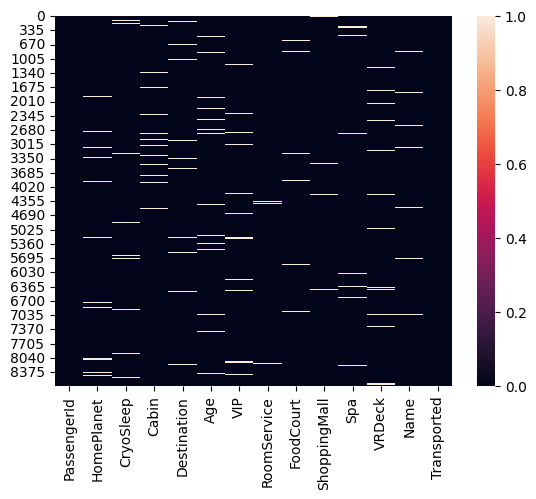

In [7]:
print(train.isnull().sum())
sns.heatmap(train.isnull())

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


<Axes: >

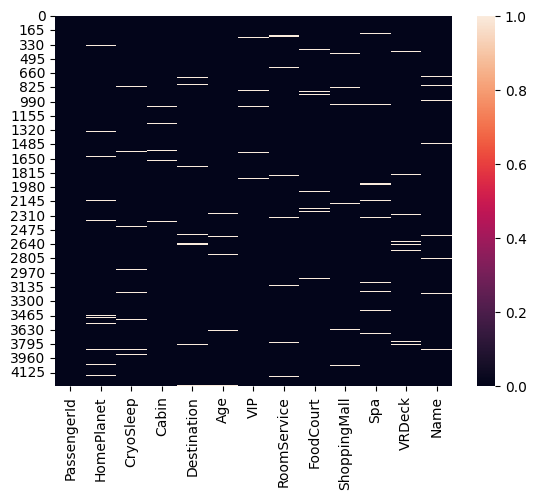

In [8]:
print(test.isnull().sum())
sns.heatmap(test.isnull())

# **Объединение train и test**

In [9]:
train_test = pd.merge(train,test,how='outer')

In [10]:
train_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN
12966,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
12967,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
12968,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [11]:
train_test.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

# **Количественные признаки**

In [12]:
numeric_categories_df = train_test.select_dtypes(exclude=object)

In [13]:
numeric_categories_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
12965,43.0,0.0,0.0,0.0,0.0,0.0
12966,18.0,0.0,0.0,0.0,0.0,0.0
12967,26.0,0.0,0.0,1872.0,1.0,0.0
12968,32.0,0.0,1049.0,0.0,353.0,3235.0


In [14]:
numeric_categories_df['total'] = numeric_categories_df.loc[:,'RoomService':].sum(axis=1)

In [15]:
numeric_categories_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,736.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1091.0
...,...,...,...,...,...,...,...
12965,43.0,0.0,0.0,0.0,0.0,0.0,0.0
12966,18.0,0.0,0.0,0.0,0.0,0.0,0.0
12967,26.0,0.0,0.0,1872.0,1.0,0.0,1873.0
12968,32.0,0.0,1049.0,0.0,353.0,3235.0,4637.0


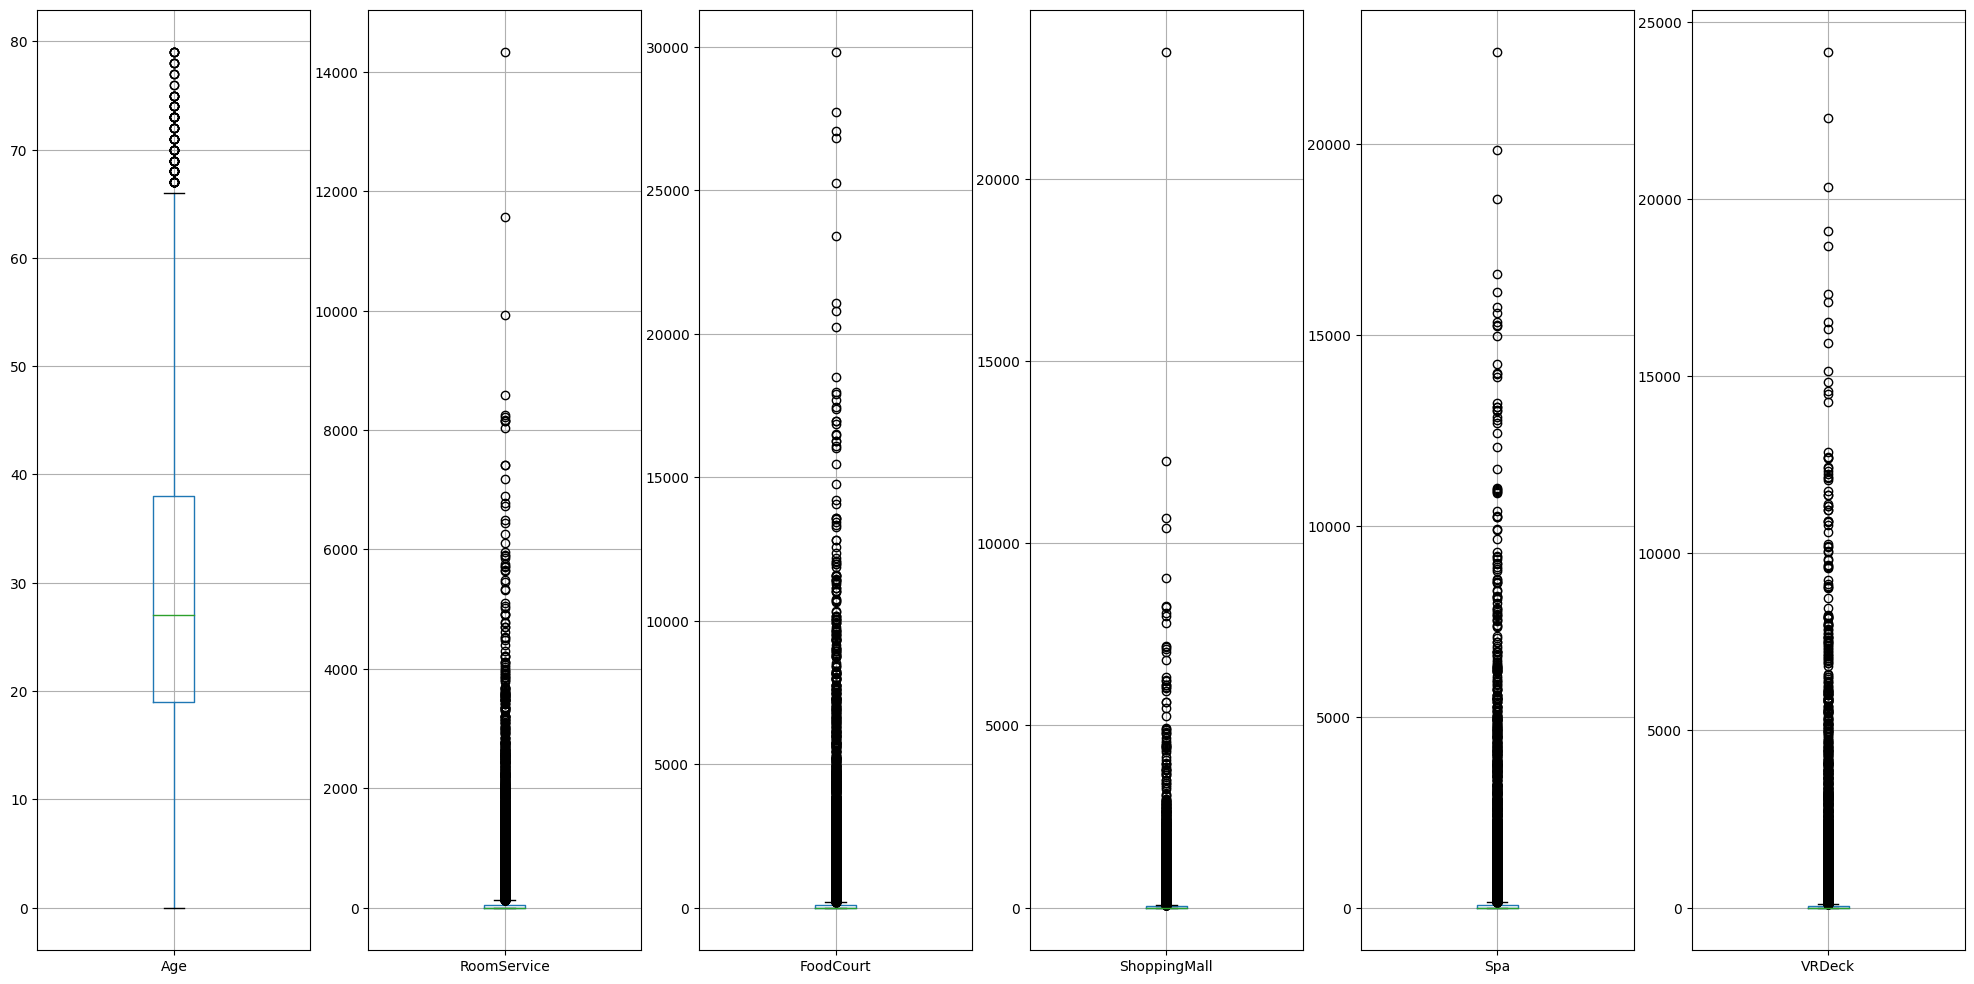

In [16]:
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20, 10)
fig.tight_layout()
i = 0
for ax in axes:
    numeric_categories_df.boxplot(column=list(numeric_categories_df)[i],ax=ax)
    i += 1

In [17]:
numeric_categories_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000,12970.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482,1433.221049
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223,2807.369708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000,1442.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


In [18]:
numeric_categories_df[numeric_categories_df.total == 0].count()

Age             5328
RoomService     5350
FoodCourt       5335
ShoppingMall    5311
Spa             5335
VRDeck          5332
total           5457
dtype: int64

In [19]:
train_test_new = train_test
train_test_new['total'] = numeric_categories_df['total']

In [20]:
train_test_new

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,total
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,0.0
12966,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0
12967,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0
12968,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4637.0


In [21]:
train_test_new['Group'] = [i.split('_')[0] for i in train_test_new.PassengerId]
train_test_new['NumGroup'] = [i.split('_')[1] for i in train_test_new.PassengerId]

In [22]:
means_comfort_sums = train_test_new.groupby('Group').agg({'RoomService':'mean','FoodCourt':'mean','ShoppingMall':'mean','Spa':'mean','VRDeck':'mean'}).reset_index()

room_service_nan = train_test_new[['PassengerId','Group','RoomService']][train_test_new.RoomService.isnull()]
food_court_nan = train_test_new[['PassengerId','Group','FoodCourt']][train_test_new.FoodCourt.isnull()]
shopping_mall_nan = train_test_new[['PassengerId','Group','ShoppingMall']][train_test_new.ShoppingMall.isnull()]
spa_nan = train_test_new[['PassengerId','Group','Spa']][train_test_new.Spa.isnull()]
vrdeck_nan = train_test_new[['PassengerId','Group','VRDeck']][train_test_new.VRDeck.isnull()]

In [23]:
for i in range(len(train_test_new)):
    if pd.isnull(train_test_new.iloc[i].RoomService):
        train_test_new.iat[i,7] = means_comfort_sums[means_comfort_sums.Group == train_test_new.iloc[i].Group].RoomService
        
    if pd.isnull(train_test_new.iloc[i].FoodCourt):
        train_test_new.iat[i,8] = means_comfort_sums[means_comfort_sums.Group == train_test_new.iloc[i].Group].FoodCourt
        
    if pd.isnull(train_test_new.iloc[i].ShoppingMall):
        train_test_new.iat[i,9] = means_comfort_sums[means_comfort_sums.Group == train_test_new.iloc[i].Group].ShoppingMall
        
    if pd.isnull(train_test_new.iloc[i].Spa):
        train_test_new.iat[i,10] = means_comfort_sums[means_comfort_sums.Group == train_test_new.iloc[i].Group].Spa
        
    if pd.isnull(train_test_new.iloc[i].VRDeck):
        train_test_new.iat[i,11] = means_comfort_sums[means_comfort_sums.Group == train_test_new.iloc[i].Group].VRDeck

/tmp/ipykernel_18/3721226446.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  train_test_new.iat[i,11] = means_comfort_sums[means_comfort_sums.Group == train_test_new.iloc[i].Group].VRDeck
/tmp/ipykernel_18/3721226446.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  train_test_new.iat[i,9] = means_comfort_sums[means_comfort_sums.Group == train_test_new.iloc[i].Group].ShoppingMall
/tmp/ipykernel_18/3721226446.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  train_test_new.iat[i,7] = means_comfort_sums[means_comfort_sums.Group == train_test_new.iloc[i].Group].RoomService
/tmp/ipykernel_18/3721226446.py:6: FutureWarning: Calling float on a single element Series is deprecated and will rai

In [24]:
train_test_new['RoomService'] = train_test_new['RoomService'].fillna(0)
train_test_new['FoodCourt'] = train_test_new['FoodCourt'].fillna(0)
train_test_new['ShoppingMall'] = train_test_new['ShoppingMall'].fillna(0)
train_test_new['Spa'] = train_test_new['Spa'].fillna(0)
train_test_new['VRDeck'] = train_test_new['VRDeck'].fillna(0)

In [25]:
train_test_new.groupby('HomePlanet').agg({'Age':'mean'})

,Age
HomePlanet,
Earth,25.961995
Europa,34.336159
Mars,29.457154


In [26]:
train_test_new['Age'][train_test_new.HomePlanet == 'Earth'] = train_test_new['Age'][train_test_new.HomePlanet == 'Earth'].fillna(train_test_new['Age'][train_test_new.HomePlanet == 'Earth']
        .mean())
train_test_new['Age'][train_test_new.HomePlanet == 'Europa'] = train_test_new['Age'][train_test_new.HomePlanet == 'Europa'].fillna(train_test_new['Age'][train_test_new.HomePlanet == 'Europa']
        .mean())
train_test_new['Age'][train_test_new.HomePlanet == 'Mars'] = train_test_new['Age'][train_test_new.HomePlanet == 'Mars'].fillna(train_test_new['Age'][train_test_new.HomePlanet == 'Mars']
        .mean())
train_test_new['Age'] = train_test_new['Age'].fillna(train_test_new['Age'].mean())

/tmp/ipykernel_18/535362774.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_test_new['Age'][train_test_new.HomePlanet == 'Earth'] = train_test_new['Age'][train_test_new.HomePlanet == 'Earth'].fillna(train_test_new['Age'][train_test

In [27]:
train_test_new.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age                0
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
total              0
Group              0
NumGroup           0
dtype: int64

# **Категориальные признаки**

In [28]:
train_test_new['total'] = train_test_new.loc[:,'RoomService':'VRDeck'].sum(axis=1)

<Axes: xlabel='total', ylabel='count'>

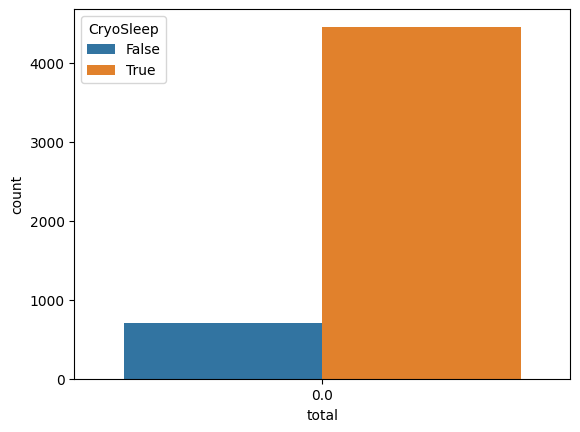

In [29]:
sns.countplot(data=train_test_new[train_test_new.total==0],x='total',hue='CryoSleep')

Скорей всего те, кто не платил ни за что и не спали - экипаж корабля

In [30]:
train_test_new['CryoSleep'][train_test_new.total == 0] = train_test_new['CryoSleep'][train_test_new.total == 0].fillna(True)
train_test_new['CryoSleep'] = train_test_new['CryoSleep'].fillna(False)

/tmp/ipykernel_18/776412832.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_test_new['CryoSleep'][train_test_new.total == 0] = train_test_new['CryoSleep'][train_test_new.total == 0].fillna(True)
/tmp/ipykernel_18/776412832.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer

In [31]:
train_test_new[(train_test_new.VIP == True)].groupby('HomePlanet').agg({'PassengerId':'count'})

,PassengerId
HomePlanet,
Europa,177
Mars,90


In [32]:
len(train_test_new[(train_test_new.VIP == True) & (train_test_new.Transported== True)])/len(train_test_new[(train_test_new.VIP == True) & (train_test_new.Transported== False)])

0.6178861788617886

Большинство VIP перенесено в другое измерение

In [33]:
train_test_new['VIP'] = train_test_new['VIP'].fillna(False)

/tmp/ipykernel_18/469697152.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_test_new['VIP'] = train_test_new['VIP'].fillna(False)


In [34]:
train_test_new.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep          0
Cabin            299
Destination      274
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
total              0
Group              0
NumGroup           0
dtype: int64

In [35]:
train_test_new.groupby(['Destination','HomePlanet']).agg({'PassengerId':'count'})

PassengerId
Destination   HomePlanet             
55 Cancri e   Earth               984
              Europa             1310
              Mars                294
PSO J318.5-22 Earth              1065
              Europa               29
              Mars                 67
TRAPPIST-1e   Earth              4672
              Europa             1737
              Mars               2256

In [36]:
train_test_new.groupby(['HomePlanet','Destination']).agg({'PassengerId':'count'})

PassengerId
HomePlanet Destination               
Earth      55 Cancri e            984
           PSO J318.5-22         1065
           TRAPPIST-1e           4672
Europa     55 Cancri e           1310
           PSO J318.5-22           29
           TRAPPIST-1e           1737
Mars       55 Cancri e            294
           PSO J318.5-22           67
           TRAPPIST-1e           2256

In [37]:
train_test_new['HomePlanet'][train_test_new.Destination == 'PSO J318.5-22'] = train_test_new['HomePlanet'][train_test_new.Destination == 'PSO J318.5-22'].fillna('Earth')
train_test_new['Destination'][train_test_new.HomePlanet == 'Mars'] = train_test_new['Destination'][train_test_new.HomePlanet == 'Mars'].fillna('TRAPPIST-1e')

/tmp/ipykernel_18/2428586417.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_test_new['HomePlanet'][train_test_new.Destination == 'PSO J318.5-22'] = train_test_new['HomePlanet'][train_test_new.Destination == 'PSO J318.5-22'].fillna

In [38]:
train_test_new.isnull().sum()

PassengerId        0
HomePlanet       265
CryoSleep          0
Cabin            299
Destination      207
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
total              0
Group              0
NumGroup           0
dtype: int64

Заменим в 'HomePlanet','Destination' пропущенные значения на наиболее встречающие

In [39]:
imputer = SimpleImputer(strategy="most_frequent")

categories_imp = ['HomePlanet','Destination']

train_test_new[categories_imp] = pd.DataFrame(imputer.fit_transform(train_test_new[categories_imp]),columns=categories_imp)

В Cabin так сделать нельзя, я считаю, поэтому на место пропущенных значениях вставим, которые рядом (запустить 2 раза надо!!!)

In [40]:
for i in range(len(train_test_new)):
    if i != 0  and pd.isnull(train_test_new.iloc[i].Cabin):
        train_test_new.iat[i,3] = train_test_new.iloc[i-1].Cabin
    elif i == 0 and pd.isnull(train_test_new.iloc[i].Cabin):
        train_test_new.iat[i,3] = train_test_new.iloc[i+1].Cabin
        
for i in range(len(train_test_new)):
    if i != 0  and pd.isnull(train_test_new.iloc[i].Cabin):
        train_test_new.iat[i,3] = train_test_new.iloc[i-1].Cabin
    elif i == 0 and pd.isnull(train_test_new.iloc[i].Cabin):
        train_test_new.iat[i,3] = train_test_new.iloc[i+1].Cabin

In [41]:
train_test_new.isnull().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
total              0
Group              0
NumGroup           0
dtype: int64

In [42]:
train_test_new['Deck'] = [i.split('/')[0] for i in list(train_test_new['Cabin'])]
train_test_new['Num'] = [i.split('/')[1] for i in list(train_test_new['Cabin'])]
train_test_new['Side'] = [i.split('/')[2] for i in list(train_test_new['Cabin'])]

In [43]:
train_test_new = train_test_new.drop(columns=['NumGroup','VIP'],axis=1)

In [44]:
train_test_new = pd.get_dummies(data=train_test_new,columns=['CryoSleep','Side'],drop_first=True,dtype=int)
train_test_new = pd.get_dummies(data=train_test_new,columns=['HomePlanet','Destination','Deck'],dtype=int)

In [45]:
train_test_new = train_test_new.drop(columns=['Num','Name'],axis=1)

Num - ненужная колонка, каждое значение практически уникально

In [46]:
train_test_new

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,total,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0001_01,B/0/P,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0,1,0,1,0,0,0,0,0,0
1,0002_01,F/0/S,24.0,109.0,9.0,25.0,549.0,44.0,True,736.0,...,0,1,0,0,0,0,0,1,0,0
2,0003_01,A/0/S,58.0,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,...,0,1,1,0,0,0,0,0,0,0
3,0003_02,A/0/S,33.0,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,...,0,1,1,0,0,0,0,0,0,0
4,0004_01,F/1/S,16.0,303.0,70.0,151.0,565.0,2.0,True,1091.0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9277_01,G/1498/S,43.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,1,0,0,0,0,0,0,0,1,0
12966,9278_01,G/1499/S,18.0,0.0,0.0,0.0,0.0,0.0,False,0.0,...,1,0,0,0,0,0,0,0,1,0
12967,9279_01,G/1500/S,26.0,0.0,0.0,1872.0,1.0,0.0,True,1873.0,...,0,1,0,0,0,0,0,0,1,0
12968,9280_01,E/608/S,32.0,0.0,1049.0,0.0,353.0,3235.0,False,4637.0,...,0,0,0,0,0,0,1,0,0,0


# **Применим стандартизацию MinMaxScaler (чтобы значения были в диапазоне 0-1)**

In [47]:
mm = MinMaxScaler()

train_test_new.loc[:,'RoomService':'total'] = mm.fit_transform(train_test_new.loc[:,'RoomService':'total'])

In [48]:
train_test_new

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,total,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0001_01,B/0/P,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0,1,0,1,0,0,0,0,0,0
1,0002_01,F/0/S,24.0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.020452,...,0,1,0,0,0,0,0,1,0,0
2,0003_01,A/0/S,58.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,0.288521,...,0,1,1,0,0,0,0,0,0,0
3,0003_02,A/0/S,33.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,0.143830,...,0,1,1,0,0,0,0,0,0,0
4,0004_01,F/1/S,16.0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.030317,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9277_01,G/1498/S,43.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,...,1,0,0,0,0,0,0,0,1,0
12966,9278_01,G/1499/S,18.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1,0,0,0,0,0,0,0,1,0
12967,9279_01,G/1500/S,26.0,0.000000,0.000000,0.079687,0.000045,0.000000,1.0,0.052047,...,0,1,0,0,0,0,0,0,1,0
12968,9280_01,E/608/S,32.0,0.000000,0.035186,0.000000,0.015753,0.134049,0.0,0.128852,...,0,0,0,0,0,0,1,0,0,0


# **Разъединим train и тест**

In [49]:
train_new = train_test_new[train_test_new.Transported.notnull()]
test_new = train_test_new[train_test_new.Transported.isnull()]

train_new = train_new.drop(columns=['PassengerId','Cabin','Group'],axis=1)
test_new = test_new.drop(columns=['PassengerId','Cabin','Group','Transported'],axis=1)

In [50]:
train_new = pd.get_dummies(data=train_new,columns=['Transported'],drop_first=True)

In [51]:
train_new

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total,CryoSleep_True,Side_S,HomePlanet_Earth,...,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Transported_1.0
0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,...,1,0,1,0,0,0,0,0,0,False
1,24.0,0.007608,0.000302,0.001064,0.024500,0.001823,0.020452,0,1,1,...,1,0,0,0,0,0,1,0,0,True
2,58.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.288521,0,1,0,...,1,1,0,0,0,0,0,0,0,False
3,33.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.143830,0,1,0,...,1,1,0,0,0,0,0,0,0,False
4,16.0,0.021149,0.002348,0.006428,0.025214,0.000083,0.030317,0,1,1,...,1,0,0,0,0,0,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12964,41.0,0.000000,0.228726,0.000000,0.073322,0.003066,0.237197,0,0,0,...,0,1,0,0,0,0,0,0,0,False
12966,18.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,...,0,0,0,0,0,0,0,1,0,False
12967,26.0,0.000000,0.000000,0.079687,0.000045,0.000000,0.052047,0,1,1,...,1,0,0,0,0,0,0,1,0,True
12968,32.0,0.000000,0.035186,0.000000,0.015753,0.134049,0.128852,0,1,0,...,0,0,0,0,0,1,0,0,0,False


In [52]:
train_new['Transported_1.0'] = train_new['Transported_1.0'].astype(int)

In [53]:
train_new = train_new.rename(columns={'Transported_1.0':'Transported_True'})

In [54]:
train_new

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total,CryoSleep_True,Side_S,HomePlanet_Earth,...,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Transported_True
0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,24.0,0.007608,0.000302,0.001064,0.024500,0.001823,0.020452,0,1,1,...,1,0,0,0,0,0,1,0,0,1
2,58.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.288521,0,1,0,...,1,1,0,0,0,0,0,0,0,0
3,33.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.143830,0,1,0,...,1,1,0,0,0,0,0,0,0,0
4,16.0,0.021149,0.002348,0.006428,0.025214,0.000083,0.030317,0,1,1,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12964,41.0,0.000000,0.228726,0.000000,0.073322,0.003066,0.237197,0,0,0,...,0,1,0,0,0,0,0,0,0,0
12966,18.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,...,0,0,0,0,0,0,0,1,0,0
12967,26.0,0.000000,0.000000,0.079687,0.000045,0.000000,0.052047,0,1,1,...,1,0,0,0,0,0,0,1,0,1
12968,32.0,0.000000,0.035186,0.000000,0.015753,0.134049,0.128852,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [55]:
test_new

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total,CryoSleep_True,Side_S,HomePlanet_Earth,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
16,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,...,0,1,0,0,0,0,0,0,1,0
22,19.000000,0.000000,0.000302,0.000000,0.125982,0.000000,0.078695,0,1,1,...,0,1,0,0,0,0,0,1,0,0
23,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,...,0,0,0,0,1,0,0,0,0,0
30,38.000000,0.000000,0.223124,0.000000,0.008077,0.024241,0.206130,0,1,0,...,0,1,0,0,1,0,0,0,0,0
32,20.000000,0.000698,0.000000,0.027030,0.000000,0.000000,0.017923,0,1,1,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12950,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,...,0,1,0,0,0,0,0,0,1,0
12954,42.000000,0.000000,0.028410,0.000724,0.000446,0.005967,0.028288,0,0,1,...,0,1,0,0,0,0,0,0,1,0
12956,29.457154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,...,0,0,0,0,0,1,0,0,0,0
12959,34.336159,0.000000,0.089894,0.000000,0.000000,0.021672,0.089004,0,0,0,...,0,1,0,0,0,1,0,0,0,0


# **Выбор модели**

In [56]:
X = train_new.drop(columns=['Transported_True'],axis=1)
y = train_new.Transported_True

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

### **Градиентный бустинг (XGB)**

In [58]:
xgb_clf = XGBClassifier(n_estimators=100,max_depth=6,max_leaves=10,max_bin=400,gamma=1,reg_lambda=1.7)

parametrs_xgb_clf = {
    'learning_rate': [0.82],
}
search_xgb = GridSearchCV(xgb_clf,param_grid=parametrs_xgb_clf,cv=10)

In [59]:
search_xgb.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=1,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=400,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=6,
                                     max_leaves=10, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.82]})

In [60]:
print('Лучшие параметры: {}'.format(search_xgb.best_params_))
print('')
print('Score по тестовой выборке: {}'.format(search_xgb.best_estimator_.score(X_test,y_test)))
print('Score по тренировочной выборке: {}'.format(search_xgb.best_estimator_.score(X_train,y_train)))
print('')
print('Precision_score по тестовой выборке: {}'.format(precision_score(y_test,search_xgb.best_estimator_.predict(X_test))))
print('Precision_score по тренировочной выборке: {}'.format(precision_score(y_train,search_xgb.best_estimator_.predict(X_train))))
print('')
print('Recall_score по тестовой выборке: {}'.format(recall_score(y_test,search_xgb.best_estimator_.predict(X_test))))
print('Recall_score по тренировочной выборке: {}'.format(recall_score(y_train,search_xgb.best_estimator_.predict(X_train))))
print('')
print('F1_score по тестовой выборке: {}'.format(f1_score(y_test,search_xgb.best_estimator_.predict(X_test))))
print('F1_score по тренировочной выборке: {}'.format(f1_score(y_train,search_xgb.best_estimator_.predict(X_train))))

Лучшие параметры: {'learning_rate': 0.82}

Score по тестовой выборке: 0.8137074517019319
Score по тренировочной выборке: 0.8421537045559134

Precision_score по тестовой выборке: 0.7897822445561139
Precision_score по тренировочной выборке: 0.8282798833819242

Recall_score по тестовой выборке: 0.8596171376481313
Recall_score по тренировочной выборке: 0.8658945443462359

F1_score по тестовой выборке: 0.823221300742034
F1_score по тренировочной выборке: 0.8466696468484578


In [61]:
best_search_xgb_clf = search_xgb.best_estimator_

In [62]:
features = best_search_xgb_clf.feature_importances_
features_df = pd.DataFrame({'features':list(X_train),'feature_importances':features})
features_df.sort_values('feature_importances',ascending=False)

,features,feature_importances
6,total,0.163142
9,HomePlanet_Earth,0.126506
7,CryoSleep_True,0.115679
19,Deck_E,0.063279
2,FoodCourt,0.053035
21,Deck_G,0.050750
8,Side_S,0.046437
3,ShoppingMall,0.045541
5,VRDeck,0.044497
10,HomePlanet_Europa,0.042441


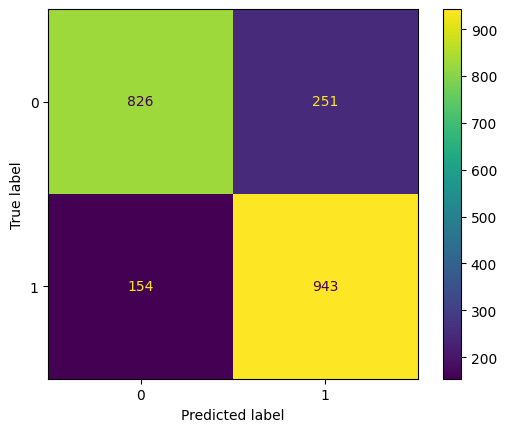

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_search_xgb_clf.predict(X_test)

confusion_matrix = confusion_matrix(list(y_test),y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()

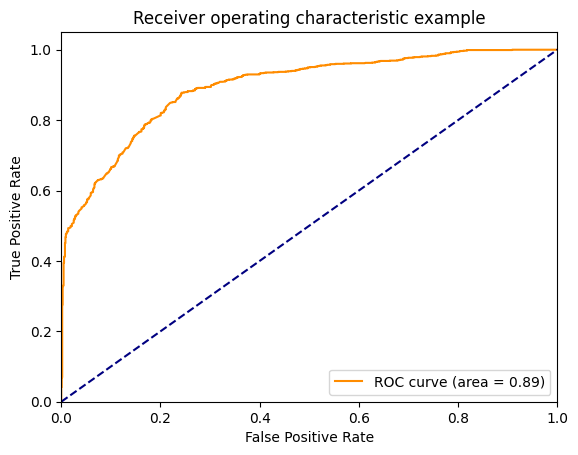

In [64]:
y_pred_prob = best_search_xgb_clf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [65]:
predict_by_xgb = best_search_xgb_clf.fit(X,y).predict(test_new)

In [66]:
sample = pd.concat([test['PassengerId'],pd.Series([True if i==1 else False for i in predict_by_xgb],name='Transported')],axis=1)

In [67]:
sample.to_csv('submission.csv',index=False)